### CFs and forests definitions

In [1]:
import os

In [2]:
country = 'KHM'
os.chdir('/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/My Drive/DISES/batched-predictions-branch')
data_folder = 'data/'

In [3]:
import geopandas as gpd
import matplotlib.patches as mpatches
import contextily as ctx
import matplotlib.pyplot as plt
import pandas as pd
import functions as fn
import rasterio
from rasterio.plot import show

- Acording to Roberto Toto, the file with the latest CF shapes is here:
- 'DISES shared/Boundary and forest cover change sub-groups folder/Boundary Data/Cambodia/CF Boundary Cambodia/Cambodia Shapefile 5-2-2023/All Cambodia 599 CF 5-2-2023/All Cambodia 599 CF 5-2-2023.shp'

In [4]:
cfs_path = '/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/.shortcut-targets-by-id/1Y83sGckPnURtqsg-y0FRgK1eOjNe7TSz/DISES shared/Boundary and forest cover change sub-groups folder/Boundary Data/Cambodia/CF Boundary Cambodia/Cambodia Shapefile 5-2-2023/All Cambodia 599 CF 5-2-2023/All Cambodia 599 CF 5-2-2023.shp'
cfs = gpd.read_file(cfs_path)

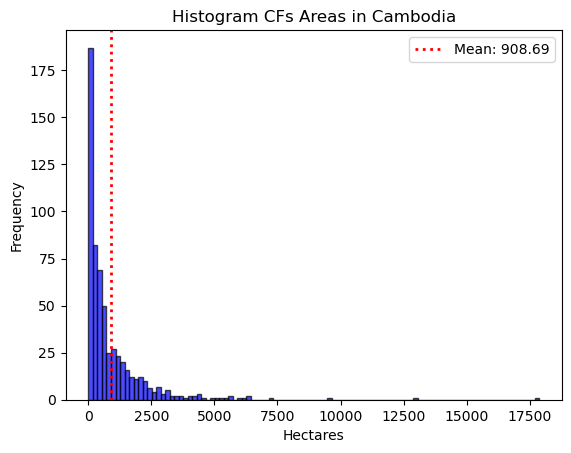

In [5]:
fn.plot_histogram_with_mean(cfs, 'HECTARES', title='Histogram CFs Areas in Cambodia', bins=100)

In [6]:
#Find the smallest and the 25th percentile threshold
cfs['HECTARES'].describe()

count      598.000000
mean       908.693031
std       1445.570607
min          0.000000
25%        129.698655
50%        425.524700
75%       1139.594066
max      17889.384070
Name: HECTARES, dtype: float64

### TTC for Cambodia
- Aquí desde GDrive los archivos que fueron "corregidos" de acuerdo a pixeles de plantaciones: https://drive.google.com/drive/folders/18AM4jb5hmH9vsj_tD0rXLVvg7kt9z--K
- El TCC modificado esta como bandas "tcc'año'_new"

In [7]:
year = 2005 #2005 is the base year for the matching process 

In [8]:
tcc_path = os.path.join(data_folder, f'TCC_Adjusted_Images/TCC_PlantAdjusted_30m_{year}.tif')

In [9]:
tcc_path

'data/TCC_Adjusted_Images/TCC_PlantAdjusted_30m_2005.tif'

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
#Clip the tcc raster to exclude areas already designated as CF
clipped_raster_path = 'temp_files/clipped_tcc.tif'

In [11]:
fn.clip_raster_exclude_shape(tcc_path, cfs_path, clipped_raster_path)

### Indentification of forested areas

In [12]:
import rasterio
import numpy as np
from scipy.ndimage import label, measurements
import geopandas as gpd
from shapely.geometry import Polygon

def filter_raster_by_percentage_and_area(raster_path, percentage, min_area_hectares, return_shapefile=False, output_shapefile_path=None):
    """
    Identifies zones in a raster where pixels exceed a percentage threshold and
    have a minimum contiguous area in hectares. Optionally returns a shapefile of the zones.

    Parameters:
        raster_path (str): Path to the input raster file.
        percentage (float): Percentage threshold for pixel values.
        min_area_hectares (float): Minimum area of zones to identify, in hectares.
        return_shapefile (bool): If True, returns a shapefile of the zones.
        output_shapefile_path (str): Path to save the output shapefile (required if return_shapefile is True).

    Returns:
        numpy.ndarray or None: Binary array with 1 indicating valid zones and 0 otherwise (if return_shapefile is False).
    """
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)  # Read the first band
        transform = src.transform

        # Calculate pixel area in square meters from raster resolution
        pixel_width = src.res[0]  # Width of a pixel in meters
        pixel_height = src.res[1]  # Height of a pixel in meters
        pixel_area_m2 = pixel_width * pixel_height

        # Create a binary mask of pixels exceeding the percentage threshold
        binary_mask = raster_data > percentage

        structure_4 = np.array([[0, 1, 0], 
                        [1, 1, 1], 
                        [0, 1, 0]])
        labeled_array, num_features = label(binary_mask, structure=structure_4)  # Use 4-connectivity


        # Calculate pixel areas in hectares
        min_area_pixels = (min_area_hectares * 10_000) / pixel_area_m2

        # Initialize an output mask for valid zones
        valid_zones = np.zeros_like(raster_data, dtype=np.uint8)

        geometries = []

        # Vectorized region processing
        region_areas = measurements.sum(binary_mask, labeled_array, index=np.arange(1, num_features + 1))
        large_regions = np.where(region_areas >= min_area_pixels)[0] + 1

        for region_label in large_regions:
            region = labeled_array == region_label
            valid_zones[region] = 1

            if return_shapefile:
                # Create a polygon for the region
                mask = (labeled_array == region_label).astype(np.uint8)
                shapes = rasterio.features.shapes(mask, transform=transform)
                for shape, value in shapes:
                    if value == 1:
                        geometries.append(Polygon(shape['coordinates'][0]))

        if return_shapefile:
            if not output_shapefile_path:
                raise ValueError("Output shapefile path must be provided if return_shapefile is True.")

            # Create a GeoDataFrame from the geometries
            gdf = gpd.GeoDataFrame({"geometry": geometries}, crs=src.crs)
            gdf.to_file(output_shapefile_path, driver="ESRI Shapefile")

            return None

    return valid_zones

In [ ]:
# Identify forested areas
fa_shape_path = os.path.join('/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/My Drive/DISES/batched-predictions-branch/data/KHM/forested_areas', 'fa_70pc_129has_4conn.shp')
filter_raster_by_percentage_and_area(clipped_raster_path, percentage=70, min_area_hectares=129, return_shapefile=True, output_shapefile_path=fa_shape_path)

### Definition of a forest

In [ ]:
#Calculate avergae average level of TC in CFs:
avg_value = fn.calculate_average_raster_value(tcc_path, cfs_path)
print(f"Average Value: {avg_value}")

### Find villages closest to CFs

- First we find the villages closest to each community forest and we consider those as treatment.
- Then we take the treatment villages out and find the villages closest to either a CF or an FA, and consider them control. 

In [13]:
cfs_path = '/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/.shortcut-targets-by-id/1Y83sGckPnURtqsg-y0FRgK1eOjNe7TSz/DISES shared/Boundary and forest cover change sub-groups folder/Boundary Data/Cambodia/CF Boundary Cambodia/Cambodia Shapefile 5-2-2023/All Cambodia 599 CF 5-2-2023/All Cambodia 599 CF 5-2-2023.shp'
cfs = gpd.read_file(cfs_path)

In [14]:
crs = cfs.crs

In [15]:
fa_shape_path = os.path.join('/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/My Drive/DISES/batched-predictions-branch/data/KHM/forested_areas', 'fa_70pc_129has_4conn.shp')
fas = gpd.read_file(fa_shape_path)
fas = fas.to_crs(crs)

In [16]:
#Import villages shape file 
vlgs_path = os.path.join('/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/.shortcut-targets-by-id/1UFnD8ofHi_4YXqnGCH4FLW8bapLdp4qX/DISES SIG/Dataset Information/Shapefiles/Cambodia_Admin-2015/Villages.shp')
vlgs = gpd.read_file(vlgs_path)
vlgs = fn.exclude_zero_coordinates(vlgs)
vlgs = vlgs.to_crs(crs) #Check crs to make sure they are the same

#### Find the nearest villages

In [17]:
from shapely.ops import nearest_points

# Helper function to find the nearest village to a geometry
def find_nearest(village_gdf, target_geom):
    # Find the nearest point in the village dataset to the target geometry
    nearest = village_gdf.iloc[village_gdf.distance(target_geom).idxmin()]
    return nearest

# 1. Find treatment villages (nearest to each CF)
treatment_villages = []
for _, cf_geom in cfs.iterrows():
    nearest_village = find_nearest(vlgs, cf_geom.geometry)
    treatment_villages.append(nearest_village)

treatment_villages_gdf = gpd.GeoDataFrame(treatment_villages, crs=crs)

treatment_path = os.path.join('/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/My Drive/DISES/batched-predictions-branch/data/KHM/treatment_contor_proximity/treatment_vlgs.shp')

treatment_villages_gdf.to_file(treatment_path)

In [23]:
#Exclude treatment villages from the dataset
vlgs2 = vlgs[~vlgs['PHUMCODE'].isin(treatment_villages_gdf['PHUMCODE'])]

In [40]:
vlgs2 = vlgs2.reset_index(drop=True)

In [41]:
from shapely.validation import make_valid
# Validate geometries to avoid topology errors
cfs['geometry'] = cfs['geometry'].apply(make_valid)
fas['geometry'] = fas['geometry'].apply(make_valid)

In [42]:
gdf1 = cfs[['CF_Code', 'geometry']]
gdf1.columns = ['FID', 'geometry']

In [43]:
gdf2 = fas.copy(deep=True)

In [44]:
forests = pd.concat([gdf1, gdf2])

In [45]:
forests = forests.reset_index(drop=True)

# 2. Find control villages (nearest to each CF)

In [46]:
# 1. Find treatment villages (nearest to each CF)
control_villages = []

for _, f_geom in forests.iterrows():
    nearest_village = find_nearest(vlgs2, f_geom.geometry)
    control_villages.append(nearest_village)

In [49]:
control_villages_gdf = gpd.GeoDataFrame(control_villages, crs=crs)

In [51]:
control_path = os.path.join('/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/My Drive/DISES/batched-predictions-branch/data/KHM/treatment_contor_proximity/control_vlgs.shp')
control_villages_gdf.to_file(control_path)

In [75]:
#Create a gdf with treatment and control villages only
treatment_villages_gdf['Treatment'] = 1
control_villages_gdf['Treatment'] = 0

vlgs3 = pd.concat([treatment_villages_gdf, control_villages_gdf])

vlgs3 = vlgs3.reset_index(drop=True)

vlgs3 = vlgs3[['NUMBER', 'PHUMCODE', 'VILLAGE', 'geometry',
       'Treatment']]

#### Calculate distances from treatment and control villages

In [76]:
# Function to calculate distance to nearest geometry and add it as a column
def calculate_distances(gdf1, gdf2, name):
    """
    Calculates the distance from each geometry in gdf1 to the closest geometry in gdf2.

    Parameters:
        gdf1 (GeoDataFrame): GeoDataFrame containing geometries to calculate distances for.
        gdf2 (GeoDataFrame): GeoDataFrame containing target geometries to calculate distances to.

    Returns:
        GeoDataFrame: Updated gdf1 with a new column 'nearest_distance' containing distances in meters.
    """
    # Ensure both GeoDataFrames have the same CRS
    if gdf1.crs != gdf2.crs:
        gdf2 = gdf2.to_crs(gdf1.crs)

    # Calculate distances to the nearest geometry in gdf2 for each geometry in gdf1
    distances = gdf1.geometry.apply(lambda geom: gdf2.geometry.distance(geom).min())

    # Add distances as a new column in gdf1
    gdf1[name] = distances

    return gdf1

In [77]:
vlgs3 = calculate_distances(vlgs3, cfs, 'dist_cf_m')

In [79]:
vlgs3 = calculate_distances(vlgs3, fas, 'dist_fa_m')

In [80]:
vlgs3 = calculate_distances(vlgs3, forests, 'dist_forest_m')

In [89]:
vlgs3.drop(['NUMBER', 'PHUMCODE'], axis=1).groupby('Treatment').describe().round(2).transpose()

Treatment                    0          1
dist_cf_m     count     982.00     598.00
              mean     9852.79    1601.89
              std     17790.72    1364.02
              min         0.00       0.00
              25%      1838.67     667.67
              50%      3015.86    1268.91
              75%      9182.92    2169.25
              max    102656.87    9613.98
dist_fa_m     count     982.00     598.00
              mean    16360.28   23963.89
              std     18446.15   20139.60
              min         0.00     231.33
              25%      4181.37   10051.96
              50%      9899.75   18191.17
              75%     21988.08   32477.26
              max    164809.80  165894.83
dist_forest_m count     982.00     598.00
              mean     2980.22    1565.88
              std      2303.01    1312.31
              min         0.00       0.00
              25%      1458.46     667.01
              50%      2443.00    1256.55
              75%      3747.90    2146.96
              max     15514.30    9613.98